In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
ddf = pd.read_csv('all_faults.csv')

In [4]:
ddf.shape

(3015936, 2)

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in ddf['fault'].unique():
    
    df_temp_2 = ddf[ddf['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encode= LabelEncoder()
encode.fit(Y)
encoded_Y = encode.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [6]:
np.shape(X)

(15042, 1000)

In [7]:
Y.shape

(15042,)

In [8]:
OHE_Y.shape

(15042, 8)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.2,shuffle=True)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(12033, 1000)
(3009, 1000)
(12033, 8)
(3009, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
n_inputs = X.shape[1]
input_data_shape= Input(shape=(n_inputs,))
encoder= Dense(n_inputs)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/2)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/4)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
##n_bottleneck = round(float(n_inputs) / 8)
##bottleneck = Dense(n_bottleneck)(encoder)
encoder= Dense(n_inputs/8)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
bottleneck= encoder
decoder = Dense(n_inputs/4)(encoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs/2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)

In [14]:
output = Dense(n_inputs/125, activation='linear')(decoder)
model = Model(inputs=input_data_shape, outputs=output)
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                             

In [15]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_test,y_test))

Epoch 1/50
377/377 - 19s - loss: 0.2611 - val_loss: 1.5198 - 19s/epoch - 51ms/step
Epoch 2/50
377/377 - 16s - loss: 0.1134 - val_loss: 0.2003 - 16s/epoch - 42ms/step
Epoch 3/50
377/377 - 16s - loss: 0.0932 - val_loss: 0.1990 - 16s/epoch - 42ms/step
Epoch 4/50
377/377 - 16s - loss: 0.0785 - val_loss: 0.1184 - 16s/epoch - 41ms/step
Epoch 5/50
377/377 - 16s - loss: 0.0675 - val_loss: 0.1849 - 16s/epoch - 41ms/step
Epoch 6/50
377/377 - 15s - loss: 0.0596 - val_loss: 0.1647 - 15s/epoch - 41ms/step
Epoch 7/50
377/377 - 15s - loss: 0.0545 - val_loss: 0.1677 - 15s/epoch - 41ms/step
Epoch 8/50
377/377 - 16s - loss: 0.0490 - val_loss: 0.0692 - 16s/epoch - 41ms/step
Epoch 9/50
377/377 - 16s - loss: 0.0454 - val_loss: 0.1702 - 16s/epoch - 42ms/step
Epoch 10/50
377/377 - 16s - loss: 0.0413 - val_loss: 0.0718 - 16s/epoch - 41ms/step
Epoch 11/50
377/377 - 15s - loss: 0.0372 - val_loss: 0.0594 - 15s/epoch - 41ms/step
Epoch 12/50
377/377 - 15s - loss: 0.0331 - val_loss: 0.1011 - 15s/epoch - 40ms/step
E

In [16]:
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder.h5')

In [17]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
X = encoder.predict(X)

In [18]:
sample_size=X.shape[0]
time_steps=X.shape[1]
input_dimension=1
X_reshaped=X.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_reshaped.shape)
print(X_reshaped.shape[0])
print(X_reshaped.shape[1])
print(X_reshaped.shape[2])
print("Sample shape:\n",X_reshaped[0].shape)
print("An example sample :\n",X_reshaped[0])

After reshape:
 (15042, 125, 1)
15042
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.        ]
 [0.        ]
 [1.1767001 ]
 [1.9177892 ]
 [0.12704235]
 [0.9226855 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.5425131 ]
 [0.06165224]
 [0.9320634 ]
 [0.8553729 ]
 [0.        ]
 [1.2226701 ]
 [0.        ]
 [0.19372547]
 [0.        ]
 [1.4761713 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [3.524695  ]
 [1.0252898 ]
 [3.208235  ]
 [0.33376825]
 [0.        ]
 [0.        ]
 [0.        ]
 [3.1577528 ]
 [0.18966365]
 [1.0149589 ]
 [0.88907456]
 [0.        ]
 [0.58455384]
 [0.        ]
 [1.0072405 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.7792072 ]
 [1.1391456 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [3.5865424 ]
 [2.2786057 ]
 [0.38616395]
 [0.12401745]
 [0.        ]
 [1.1799874 ]
 [0.        ]
 [0.        ]
 [2.452632  ]
 [2.5223193 ]
 [0.        ]
 [1.0142374 ]
 [0.        ]
 [0.        ]
 [2.2135344 ]
 [0.02639365]
 [0.        ]
 

In [19]:
sample_size=X_train_encode.shape[0]
time_steps=X_train_encode.shape[1]
input_dimension=1
X_train=X_train_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_train.shape)
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])
print("Sample shape:\n",X_train[0].shape)
print("An example sample :\n",X_train[0])

After reshape:
 (12033, 125, 1)
12033
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.00000000e+00]
 [2.25586772e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.19816279e+00]
 [1.06630039e+00]
 [5.67099392e-01]
 [1.35552776e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00465953e-01]
 [0.00000000e+00]
 [1.61949396e-02]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.38891184e+00]
 [8.43528688e-01]
 [6.96909666e-01]
 [0.00000000e+00]
 [1.83652449e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.81078553e-01]
 [1.49007738e-01]
 [1.31895065e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.16063333e-01]
 [4.15856481e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.35256338e-01]
 [6.52578592e-01]
 [0.00000000e+00]
 [1.29311156e+00]
 [3.91038835e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.4833416

In [20]:
sample_size=X_test_encode.shape[0]
time_steps=X_test_encode.shape[1]
input_dimension=1
X_test=X_test_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_test.shape)
print(X_test.shape[0])
print(X_test.shape[1])
print(X_test.shape[2])
print("Sample shape:\n",X_test[0].shape)
print("An example sample :\n",X_test[0])

After reshape:
 (3009, 125, 1)
3009
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.37709558]
 [1.309918  ]
 [0.        ]
 [0.        ]
 [0.2667266 ]
 [0.16405958]
 [0.        ]
 [0.980054  ]
 [0.8076312 ]
 [0.94364375]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0660806 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.71669215]
 [0.        ]
 [0.19367498]
 [0.        ]
 [1.7461617 ]
 [1.1129327 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.77184737]
 [0.34751683]
 [0.        ]
 [1.4052103 ]
 [0.        ]
 [1.3087388 ]
 [0.        ]
 [0.        ]
 [0.1931966 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.4966395 ]
 [1.2910714 ]
 [2.3596265 ]
 [0.        ]
 [1.3380831 ]
 [0.        ]
 [0.        ]
 [1.9765316 ]
 [0.6715388 ]
 [0.        ]
 [0.        ]
 [0.41704407]
 [1.3198428 ]
 [0.        ]
 [0.        ]
 [0.8158377 ]
 [0.        ]
 [1.1501833 ]
 [0.18430114]
 [0.        ]
 [1.2127576 ]
 [0.        ]
 [0

In [25]:
X_t_sne = TSNE(n_components=2,verbose=1, perplexity=40, n_iter=300).fit_transform(X )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15042 samples in 1.036s...
[t-SNE] Computed neighbors for 15042 samples in 22.838s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15042
[t-SNE] Computed conditional probabilities for sample 2000 / 15042
[t-SNE] Computed conditional probabilities for sample 3000 / 15042
[t-SNE] Computed conditional probabilities for sample 4000 / 15042
[t-SNE] Computed conditional probabilities for sample 5000 / 15042
[t-SNE] Computed conditional probabilities for sample 6000 / 15042
[t-SNE] Computed conditional probabilities for sample 7000 / 15042
[t-SNE] Computed conditional probabilities for sample 8000 / 15042
[t-SNE] Computed conditional probabilities for sample 9000 / 15042
[t-SNE] Computed conditional probabilities for sample 10000 / 15042
[t-SNE] Computed conditional probabilities for sample 11000 / 15042
[t-SNE] Computed conditional probabilities for sample 12000 / 15042
[t-SNE] Computed conditional probabilities for s

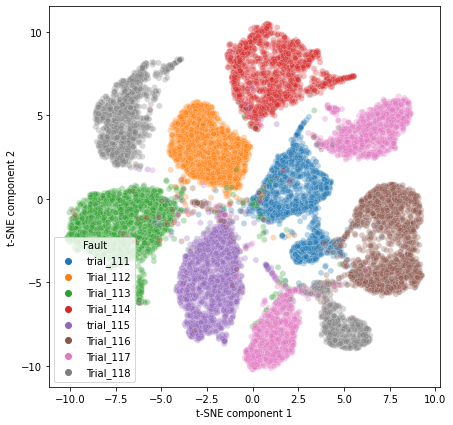

In [26]:
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])
tSNEdf['Fault']=Y

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [27]:
tSNEdf

,t-SNE component 1,t-SNE component 2,Fault
0,2.484108,3.844203,trial_111
1,3.808952,1.453565,trial_111
2,3.265503,-0.080723,trial_111
3,4.001041,0.994416,trial_111
4,1.864187,1.792950,trial_111
...,...,...,...
15037,-6.047329,4.068125,Trial_118
15038,-7.403008,4.805559,Trial_118
15039,-6.563824,3.587760,Trial_118
15040,-7.956769,4.417901,Trial_118


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten



no_classes=len(encode.classes_)
model_RNN = Sequential()
model_RNN.add(SimpleRNN(125, return_sequences=True, input_shape=(X_reshaped.shape[1],1), activation='tanh' ))
model.add(SimpleRNN(250, return_sequences=False, activation='tanh'))
model.add(Dense(500, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 125, 125)          15875     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 250)               94000     
                                                                 
 dense_12 (Dense)            (None, 500)               125500    
                                                                 
 dense_13 (Dense)            (None, 750)               375750    
                                                                 
 dense_14 (Dense)            (None, 1000)              751000    
                                                                 
 dense_15 (Dense)            (None, 8)                 8008      
                                                                 
Total params: 1,370,133
Trainable params: 1,370,133
No

In [29]:
history = model.fit(X_train ,
                    y_train,
                    epochs=50, 
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test ,y_test),
                    verbose=1)

Epoch 1/50
377/377 [==============================] - 71s 182ms/step - loss: 0.2509 - accuracy: 0.9449 - val_loss: 0.9510 - val_accuracy: 0.8229
Epoch 2/50
377/377 [==============================] - 51s 135ms/step - loss: 0.1460 - accuracy: 0.9703 - val_loss: 2.0643 - val_accuracy: 0.8342
Epoch 3/50
377/377 [==============================] - 31s 82ms/step - loss: 0.1614 - accuracy: 0.9722 - val_loss: 1.7131 - val_accuracy: 0.8046
Epoch 4/50
377/377 [==============================] - 33s 87ms/step - loss: 0.0930 - accuracy: 0.9845 - val_loss: 2.2133 - val_accuracy: 0.8338
Epoch 5/50
377/377 [==============================] - 39s 104ms/step - loss: 0.1045 - accuracy: 0.9835 - val_loss: 2.0137 - val_accuracy: 0.8282
Epoch 6/50
377/377 [==============================] - 42s 112ms/step - loss: 0.0683 - accuracy: 0.9891 - val_loss: 2.7127 - val_accuracy: 0.8302
Epoch 7/50
377/377 [==============================] - 44s 117ms/step - loss: 0.0727 - accuracy: 0.9901 - val_loss: 2.5110 - val_accu

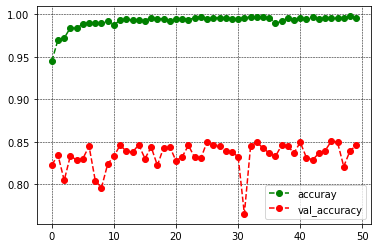

In [30]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [31]:
model_RNN.save('model_RNN.h5')

In [32]:
y_pred=model.predict(X_test)
print(y_pred)
print(y_pred.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.3308232e-20 2.1729934e-14 4.5784323e-06 ... 7.3219341e-15
  8.1725543e-19 9.9999547e-01]
 [6.0717898e-38 7.2540248e-29 4.2994468e-34 ... 5.4129413e-31
  1.0000000e+00 4.8146747e-34]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.1094202e-06 1.0858619e-05 5.3693998e-01 ... 3.5458237e-01
  2.6981314e-04 1.5147261e-02]
 [5.2180604e-12 2.5052908e-05 1.0978624e-03 ... 8.8751480e-02
  1.1771443e-04 3.4914327e-01]]
(3009, 8)


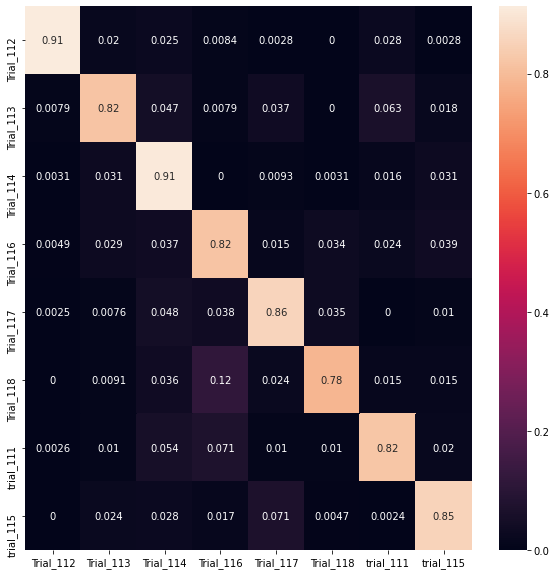

In [33]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encode.inverse_transform(y_pred)
    return y_pred






Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encode.classes_,yticklabels=encode.classes_)
plt.show()

In [34]:
print(X_train.shape)
print(X_test.shape)
print(X_train_encode.shape)
print(X_test_encode.shape)
print(y_train.shape)
print(y_test.shape)

(12033, 125, 1)
(3009, 125, 1)
(12033, 125)
(3009, 125)
(12033, 8)
(3009, 8)


In [35]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-3].output)
y_viz = dummy_ann.predict(X_train)
y_viz.shape

(12033, 750)

In [38]:
def T_SNE_plot(X_train,y_train,model,encode):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train_encode)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12033 samples in 4.788s...
[t-SNE] Computed neighbors for 12033 samples in 22.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12033
[t-SNE] Computed conditional probabilities for sample 2000 / 12033
[t-SNE] Computed conditional probabilities for sample 3000 / 12033
[t-SNE] Computed conditional probabilities for sample 4000 / 12033
[t-SNE] Computed conditional probabilities for sample 5000 / 12033
[t-SNE] Computed conditional probabilities for sample 6000 / 12033
[t-SNE] Computed conditional probabilities for sample 7000 / 12033
[t-SNE] Computed conditional probabilities for sample 8000 / 12033
[t-SNE] Computed conditional probabilities for sample 9000 / 12033
[t-SNE] Computed conditional probabilities for sample 10000 / 12033
[t-SNE] Computed conditional probabilities for sample 11000 / 12033
[t-SNE] Computed conditional probabilities for sample 12000 / 12033
[t-SNE] Computed conditional probabilities for s

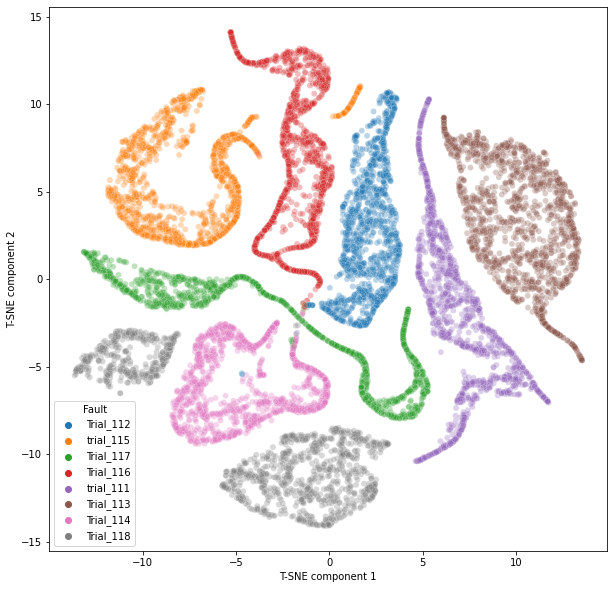

In [39]:
T_SNE_plot(X_train,y_train,model,encode)

In [40]:

y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       356
           1       0.86      0.82      0.84       380
           2       0.73      0.91      0.81       322
           3       0.78      0.82      0.80       410
           4       0.84      0.86      0.85       396
           5       0.88      0.78      0.83       330
           6       0.85      0.82      0.84       392
           7       0.88      0.85      0.86       423

    accuracy                           0.85      3009
   macro avg       0.85      0.85      0.85      3009
weighted avg       0.85      0.85      0.85      3009

